In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
from utils import read_ami_SPY_data

In [4]:
train_size = 150
test_size = 5
return_day = 10
full_size = train_size + test_size + return_day

In [5]:
data = read_ami_SPY_data()

In [6]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

In [7]:
features_to_delete = data.columns.tolist()

# ROC

In [8]:
for i in [5, 10, 20, 30]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

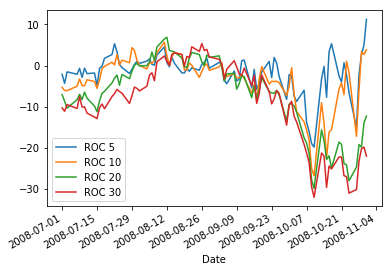

In [9]:
data['2008-07': '2008-10'][['ROC 5', 'ROC 10', 'ROC 20', 'ROC 30']].plot()

# Deviation from zero-lag exponential MA

In [10]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

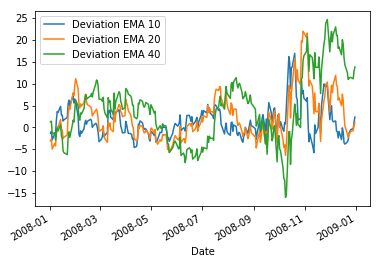

In [11]:
data['2008'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [12]:
for i, j, k in [(14, 20, 12), (12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd
#     data[f'MACD signal ({i}, {j}, {k})'] = macdsignal
#     data[f'MACD hist ({i}, {j}, {k})'] = macdhist

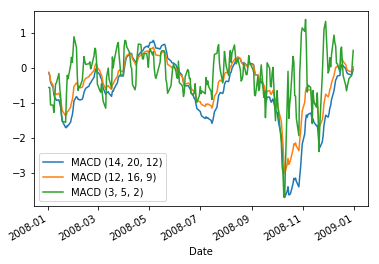

In [13]:
data['2008'][['MACD (14, 20, 12)', 'MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

In [14]:
# data['2008'][['MACD signal (12, 16, 9)', 'MACD signal (3, 5, 2)']].plot()

In [15]:
# data['2008'][['MACD hist (14, 20, 12)', 'MACD hist (12, 16, 9)', 'MACD hist (3, 5, 2)']].plot()

# RSI

In [16]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

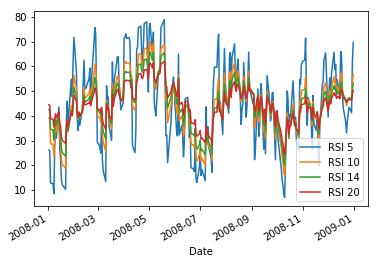

In [17]:
data['2008'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [18]:
for i, j in [(5, 10), (10, 20), (20, 40)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

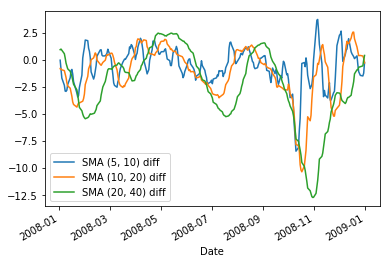

In [19]:
data['2008'][['SMA (5, 10) diff', 'SMA (10, 20) diff', 'SMA (20, 40) diff']].plot()

# ADX

In [ ]:
data['ADX 20'] = tl.ADX(high, low, close, timeperiod=20)
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)
data['ADX 7'] = tl.ADX(high, low, close, timeperiod=7)

In [ ]:
data['2005'][['ADX 7', 'ADX 14', 'ADX 20']].plot()

# CCI

In [ ]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

In [ ]:
data['2008']['CCI 14'].plot()

# STD deviation 20

In [ ]:
data['Std dev 10'] = tl.STDDEV(close, timeperiod=10)
data['Std dev 20'] = tl.STDDEV(close, timeperiod=20)

In [ ]:
data['2008'][['Std dev 10', 'Std dev 20']].plot()

# Y target value

In [ ]:
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Extreme'] = data['Close'].pct_change(return_day).rolling(return_day).std()*100

In [ ]:
data.dropna(inplace=True)
data.drop(columns=features_to_delete, inplace=True)
data.head()

### Features

In [ ]:
feature_names = data.drop(['Return', 'Extreme'], axis=1).columns

# Train and test Random Forest

In [ ]:
def to_class(y_vec, extreme):
#     y_extreme = extreme_multiplier * y_vec.rolling(test_size).std().shift(return_day).fillna(method='ffill').fillna(method='bfill')
    
    pos = y_vec > extreme
    neg = y_vec < -1*extreme

    y_vec[:] = 'Neutral'
    y_vec[pos] = 'Pos'
    y_vec[neg] = 'Neg'
    return y_vec

In [ ]:
def make_X_y(df):
    X = df.drop(['Return', 'Extreme'], axis=1)
    y = df['Return'].copy()
    ret = y.copy()
    y = to_class(y, 2.7) # df['Extreme']
    return X, y, ret

In [ ]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[-test_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[-test_size:]
    ret = ret.iloc[-test_size:]
    print('Split result before upsampling: {} -> {} + {}'.format(len(X), len(X_train), len(X_test)))
    
    last_q4 = int(train_size/4)
    last_q8 = int(train_size/8)
    last_q16 = int(train_size/16)
    X_train = pd.concat([X_train, X_train[-last_q4:], X_train[-last_q8:], X_train[-last_q16:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-last_q4:], y_train[-last_q8:], y_train[-last_q16:]], ignore_index=True)
    return X_train, X_test, y_train, y_test, ret

In [ ]:
def print_labels_distrib(y_train, y_test):
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)

In [ ]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred):
    bad_sum     = -8*np.sum(((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos')))
    np_sum      = -2*np.sum(((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg')))
    pn_sum      = -1*np.sum(((y_true == 'Pos') & (y_pred == 'Neutral')) | ((y_true == 'Neg') & (y_pred == 'Neutral')))
    good_sum    =  8*np.sum(((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg')))
    return bad_sum + np_sum + pn_sum + good_sum
scorer = make_scorer(custom_loss, greater_is_better=True)

In [ ]:
def calculate_returns(ret, y_pred):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
    return ret_sum

In [ ]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

## Train and Test

In [ ]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, ret = split_X_y(X, y, ret)
    print_labels_distrib(y_train, y_test)
    
    forest = RandomForestClassifier(n_jobs=8, class_weight='balanced_subsample')
    pipe = Pipeline(steps=[('scaler', StandardScaler()), 
#                            ('pca', PCA()), 
                           ('forest', forest)])
    
    params = {'forest__n_estimators': [100],
              'forest__max_depth': [None],
              'forest__max_features': [2,3,5],
              'forest__min_samples_split': [2,3,5],
              'forest__min_samples_leaf': [2,3],
#               'pca__n_components': [0.3, 0.7]
             }
    grid = GridSearchCV(estimator=pipe,
                        param_grid=params, 
                        scoring=scorer,
                        cv=3)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum = calculate_returns(ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.index[-1],
        'best_params': best_params,
        'features': best_estimator.steps[-1][1].feature_importances_,
        'ret_sum': ret_sum
    }
    test_params.append(param)

In [ ]:
test_params = []

for i in range(0, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1]
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

In [ ]:
indexes = [d['date'] for d in test_params]

### Random Forest parameters with Accuracy and Returns

In [ ]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [ ]:
params.sort_values('Sum of return', ascending=False)

In [ ]:
params.describe()

In [ ]:
params['Sum of return'].sum()

In [ ]:
params['Accuracy'].plot()

In [ ]:
params['Sum of return'].plot()

### Feature importances

In [ ]:
features = pd.DataFrame([d['features'] for d in test_params], index=indexes, columns=feature_names)

In [ ]:
features.idxmax(axis=1).value_counts()

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

In [ ]:
plt.figure(figsize=(10,20))
sns.violinplot(data=features, orient='h')